<h2>Adding imports</h2>

In [20]:
from timeit import timeit
from IPython.display import display
import matplotlib
# matplotlib.use("pgf")
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap
import seaborn as sns

Open the dataset

In [21]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,t,ID,DLC,d0,d1,d2,d3,d4,d5,d6,d7,dt,dt_ID,type,ones,ones_ID,Label
0,0.000000,608,8,21,30,30,48,0,143,123,44,0.000444,0.009978,none,27,3,0
1,0.000232,672,8,64,0,118,29,204,4,227,0,0.000232,0.009977,none,20,3,0
2,0.000480,704,8,20,0,0,0,0,0,0,0,0.000248,0.009981,none,2,3,0
3,0.000714,809,8,12,185,127,20,17,32,0,20,0.000234,0.009978,none,21,5,0
4,0.000955,1349,8,216,0,0,140,0,0,0,0,0.000241,0.009978,none,7,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735835,59.573580,562,8,0,0,0,8,0,0,0,0,0.000248,0.020620,none,1,4,0
1735836,59.573815,398,8,0,0,0,105,166,154,6,154,0.000235,0.013305,none,18,5,0
1735837,59.574057,401,8,6,154,6,170,6,154,0,0,0.000242,0.013092,none,18,4,0
1735838,59.574492,199,4,0,7,2,32,0,0,0,0,0.000435,0.012329,none,5,5,0


Drop a few columns

In [22]:
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "DLC", "t", "data", "ID"], inplace=True, errors="ignore")

display(df)

,dt,dt_ID,type,ones,ones_ID,Label
0,0.000444,0.009978,none,27,3,0
1,0.000232,0.009977,none,20,3,0
2,0.000248,0.009981,none,2,3,0
3,0.000234,0.009978,none,21,5,0
4,0.000241,0.009978,none,7,5,0
...,...,...,...,...,...,...
1735835,0.000248,0.020620,none,1,4,0
1735836,0.000235,0.013305,none,18,5,0
1735837,0.000242,0.013092,none,18,4,0
1735838,0.000435,0.012329,none,5,5,0


Create the training and test data

In [23]:
X_train = df.drop(columns="type")
y_train = df["type"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)

# Use feature "Label" as classification label
d_temp: pd.DataFrame = pd.concat([X_train, y_train], axis="columns")
X_train, y_train = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp: pd.DataFrame = pd.concat([X_test, y_test], axis="columns")
X_test, y_test = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp = None # Release memory

Under-sample the training set by the majority class (no attack, 0). The test set can still be inbalanced, as real world data can also be inbalanced.

In [25]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)

print(f"Labels\n\tTrain: {np.bincount(y_train)} Test: {np.bincount(y_test)}")

Labels
	Train: [128320 128320] Test: [465758  54994]


Perform a Chi Squared test to see if there are any features that aren't dependent on the classification label, "Label".

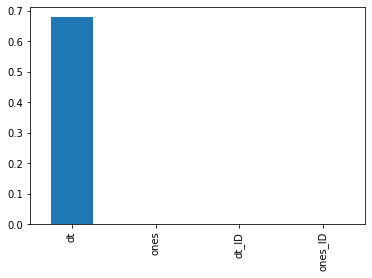

In [28]:
# Use a dataframe without "type", as it is categorical and will not be used to train later
X_train_chi = X_train.drop(columns="type")
chi_scores = chi2(X_train_chi, y_train)
p_values = pd.Series(chi_scores[1], index=X_train_chi.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()
plt.show()
X_train_chi = None # Release memory

I think this shows that the feature "dt" can be dropped as it is not dependent on the class?

Visualize the distribution of attack instances by ones counted.

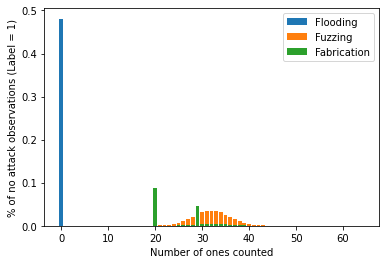

In [32]:
d_temp = pd.concat([X_train, y_train], axis="columns")
size = len(d_temp.loc[d_temp["Label"] == 1].index)
ones_prob = [[], [], []]
# zeros_prob = []
for i in range(65):
    # zeros_prob.append(len(df_all.loc[(df_all["Label"] == 0) & (df_all["ones"] == i)].index) / size)

    prob_flood = len(d_temp.loc[(d_temp["Label"] == 1) & (d_temp["ones"] == i) & (d_temp["type"] == "flood")].index) / size
    prob_fuzz = len(d_temp.loc[(d_temp["Label"] == 1) & (d_temp["ones"] == i) & (d_temp["type"] == "fuzz")].index) / size
    prob_fabr = len(d_temp.loc[(d_temp["Label"] == 1) & (d_temp["ones"] == i) & (d_temp["type"] == "fabr")].index) / size
    ones_prob[0].append(prob_flood)
    ones_prob[1].append(prob_fuzz)
    ones_prob[2].append(prob_fabr)


# zeros_prob = pd.Series(zeros_prob)
ones_prob = pd.Series(ones_prob)
# sns.lineplot(data=ones_prob)

plt.bar(x=range(0, 65), height=ones_prob[0])
plt.bar(x=range(0, 65), height=ones_prob[1])
plt.bar(x=range(0, 65), height=ones_prob[2])
plt.legend(labels=["Flooding", "Fuzzing", "Fabrication"])
# plt.bar(x=range(0, 65), height=zeros_prob)
plt.xlabel("Number of ones counted")
plt.ylabel("% of no attack observations (Label = 1)")
plt.show()

d_temp = None # Release memory